In [2]:
library("reshape2")
library("dplyr")
library("readr")
library("ggplot2")
library("randomForest");

Dataset is availiable from http://mlr.cs.umass.edu/ml/datasets/Bank+Marketing

In [9]:
bank <- read_csv2("~/Documents/kaggle/Bank/bank-full.csv")

Take a look at the number of unique data points per variable

In [10]:
sapply(bank, unique) %>%
  sapply(length)

age       job   marital education   default   balance   housing      loan 
       77        12         3         4         2      7168         2         2 
  contact       day     month  duration  campaign     pdays  previous  poutcome 
        3        31        12      1573        48       559        41         4 
        y 
        2

"The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed." - from source of data

##Input variables:
### bank client data:
    1 - age (numeric)
    2 - job : type of job (categorical)
    3 - marital : marital status (categorical)
    4 - education (categorical)
    5 - default: has credit in default? (categorical: 'no','yes','unknown')
    6 - housing: has housing loan? (categorical: 'no','yes','unknown')
    7 - loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
    8 - contact: contact communication type (categorical: 'cellular','telephone')
    9 - month: last contact month of year (categorical)
    10 - day_of_week: last contact day of the week (categorical)
    11 - duration: last contact duration, in seconds (numeric)
### other attributes:
    12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    14 - previous: number of contacts performed before this campaign and for this client (numeric)
    15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Convert categorical variables into factors so they can be used in machine learning algorithms

In [11]:
str(bank)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	45211 obs. of  17 variables:
 $ age      : int  58 44 33 47 33 35 28 42 58 43 ...
 $ job      : chr  "management" "technician" "entrepreneur" "blue-collar" ...
 $ marital  : chr  "married" "single" "married" "married" ...
 $ education: chr  "tertiary" "secondary" "secondary" "unknown" ...
 $ default  : chr  "no" "no" "no" "no" ...
 $ balance  : int  2143 29 2 1506 1 231 447 2 121 593 ...
 $ housing  : chr  "yes" "yes" "yes" "yes" ...
 $ loan     : chr  "no" "no" "yes" "no" ...
 $ contact  : chr  "unknown" "unknown" "unknown" "unknown" ...
 $ day      : int  5 5 5 5 5 5 5 5 5 5 ...
 $ month    : chr  "may" "may" "may" "may" ...
 $ duration : int  261 151 76 92 198 139 217 380 50 55 ...
 $ campaign : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays    : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ previous : int  0 0 0 0 0 0 0 0 0 0 ...
 $ poutcome : chr  "unknown" "unknown" "unknown" "unknown" ...
 $ y        : chr  "no" "no" "no" "no" ...


In [12]:
bank <- as.data.frame(unclass(bank))
str(bank)

'data.frame':	45211 obs. of  17 variables:
 $ age      : int  58 44 33 47 33 35 28 42 58 43 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 5 10 3 2 12 5 5 3 6 10 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 3 2 2 3 2 3 1 2 3 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 3 2 2 4 4 3 3 3 1 2 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 2 1 1 ...
 $ balance  : int  2143 29 2 1506 1 231 447 2 121 593 ...
 $ housing  : Factor w/ 2 levels "no","yes": 2 2 2 2 1 2 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 1 2 1 1 1 2 1 1 1 ...
 $ contact  : Factor w/ 3 levels "cellular","telephone",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ day      : int  5 5 5 5 5 5 5 5 5 5 ...
 $ month    : Factor w/ 12 levels "apr","aug","dec",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ duration : int  261 151 76 92 198 139 217 380 50 55 ...
 $ campaign : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pdays    : int  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 ...
 $ previous : int  0 0 0

####Split dataset into training (80%) and test set (20%)

In [13]:
smp_size <- floor(.8 * nrow(bank))
set.seed(123)
train_indices <- sample(seq_len(nrow(bank)), size=smp_size)
train_bank <- bank[train_indices, ]
test_bank <- bank[-train_indices, ]

####Seperate y, the variable of interest from the test set

In [14]:
y <- test_bank[,17]
test_bank <- test_bank[,-17]

### Fit random forest, use only the variables that would be availiable to the bank before the campaign started (age, job, marital, education, default, balance, housing, loan)

In [15]:
fit.forest <- randomForest(y ~ age + job + marital + education + default + balance + housing + loan, 
                            data=train_bank, importance=TRUE, ntree=1001)

####Show how the agorithm ranks variables by importantance

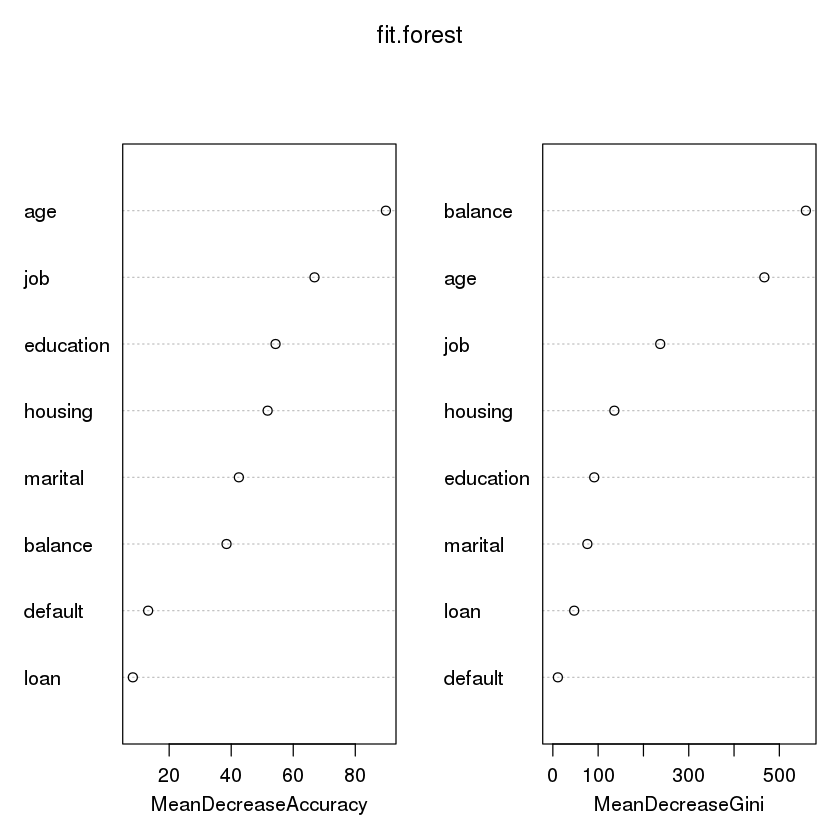

In [16]:
varImpPlot(fit.forest)

####Use model to predict y in test set and show table with results

In [22]:
predict.forest <- predict(fit.forest,test_bank) 
result.forest <- data.frame(y, predict.forest)
table(result.forest$y, result.forest$predict.forest)

     
        no  yes
  no  7992    5
  yes 1038    8

##### Where the model actually called a yes it had pretty good success, but the model rarely called a yes, There are many many false negatives, which is especially bad because in a data set like this.  Here false positives are only wasting a phone call but a false negative is losing a customer.  This is most likely a result of our unbalanced dataset, there are many more nos than yes's. 

####Lets look at the ratio of yes to no in the train set

In [23]:
ratio <- data.frame(length(subset(train_bank, y == "yes")$y), length(subset(train_bank, y == "no")$y), row.names = "count") %>%
  t() %>%
    data.frame() %>%
      mutate( percent = count / (count[1]+count[2]))
rownames(ratio) <- c("yes", "no")

In [24]:
ratio

count   percent
yes  4243 0.1173136
no  31925 0.8826864

#### Only about 10% of the repsonses were yes

###Try to improve results by artifically balancing training set

####will be using package ROSE to do this, also use it to make a ROC curve and measure the area under curve (AUC) as the way to compare models

In [28]:
library("ROSE");
bankT.rose <- ROSE(y ~ ., data=train_bank, seed=123)$data
table(bankT.rose$y)


   no   yes 
18365 17803 

#### Now the training set is balanced

Area under the curve (AUC): 0.504

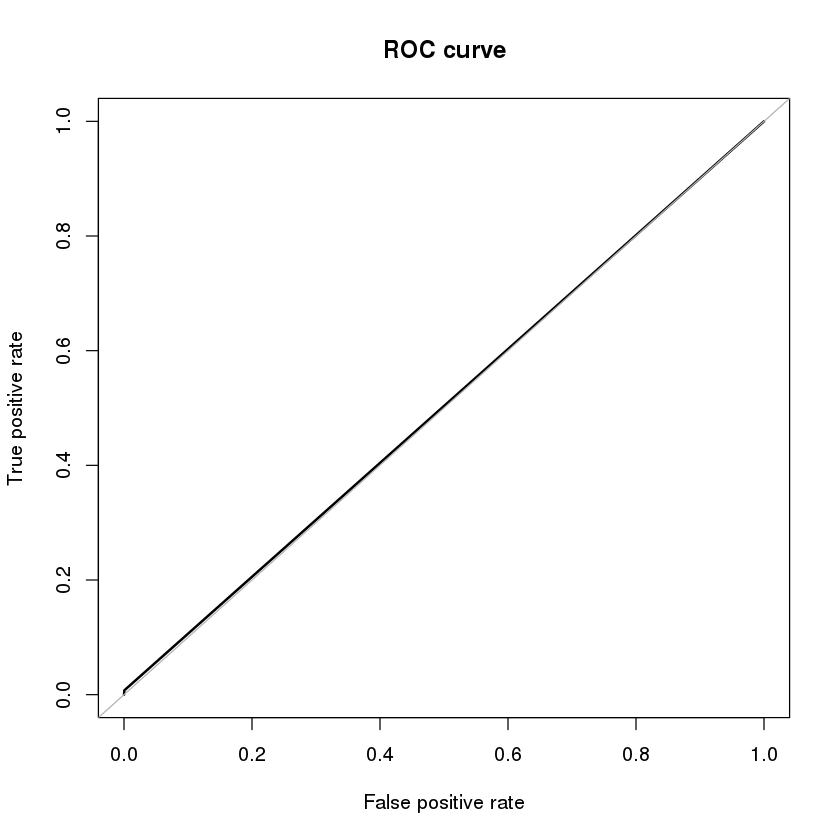

In [29]:
roc.curve(result.forest$y, result.forest$predict.forest)

#### You can see that our model with the unbalanced data set is really no better than random guessing, see if it improves by training on the balanced dataset

In [30]:
fit.forest.rose <- randomForest(y ~ age + job + marital + education + default + balance + housing + loan, 
                     data=bankT.rose, importance=TRUE, ntree=1001)

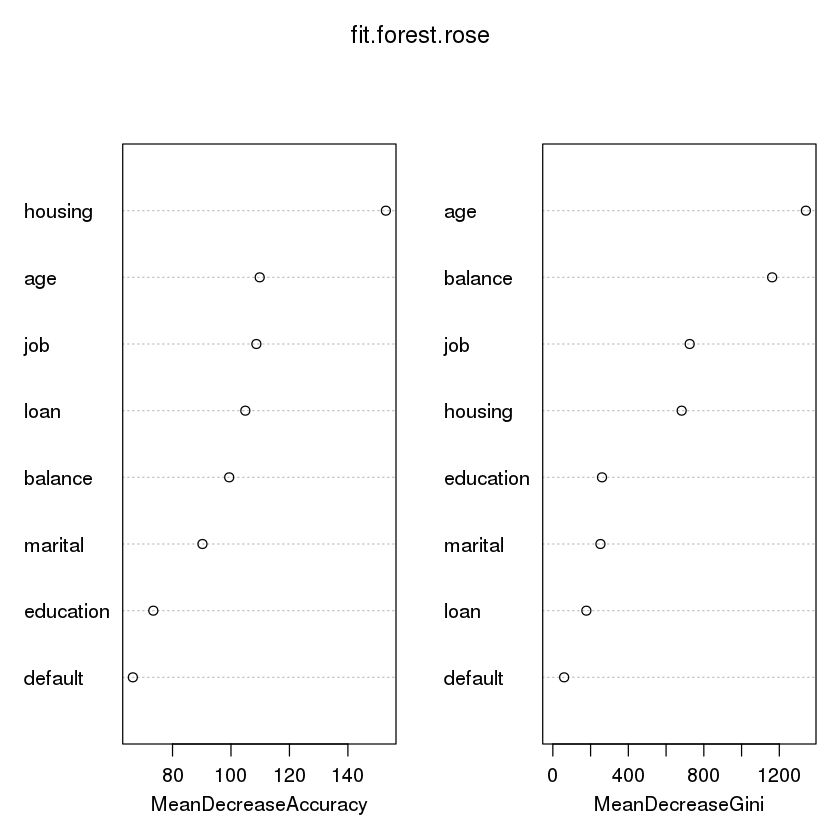

In [31]:
varImpPlot(fit.forest.rose)
predict.forest.rose <- predict(fit.forest.rose,test_bank) 
result.forest.rose <- data.frame(y, predict.forest.rose)

Area under the curve (AUC): 0.633

     
        no  yes
  no  6005 1992
  yes  508  538

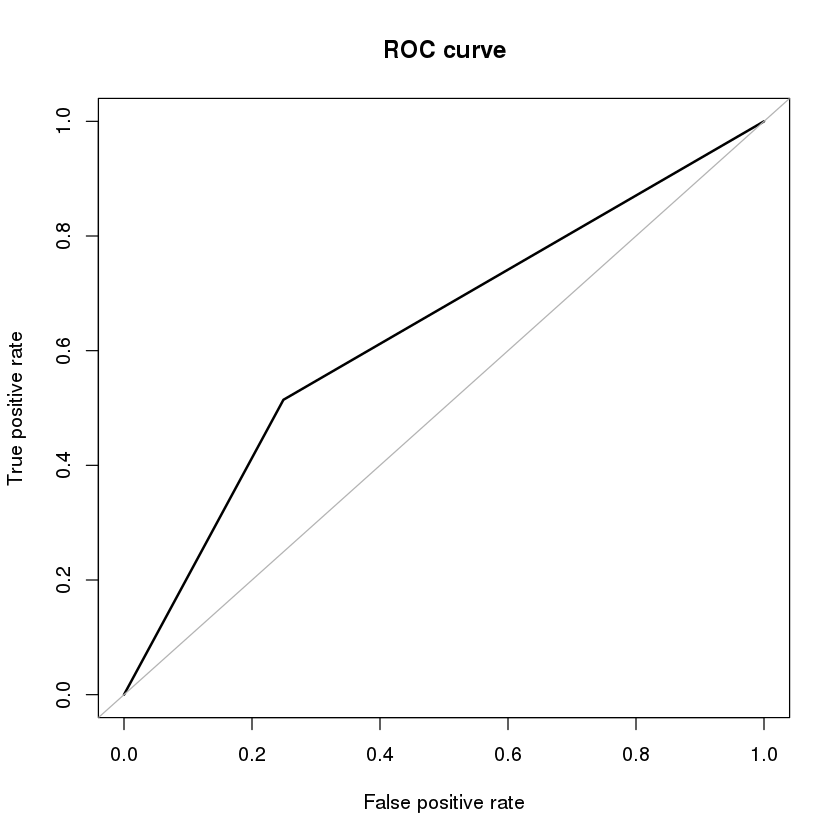

In [33]:
roc.curve(result.forest.rose$y, result.forest.rose$predict.forest.rose)
table(result.forest.rose$y, result.forest.rose$predict.forest.rose)

####much better results 

##Compare to logistic regression

Area under the curve (AUC): 0.665

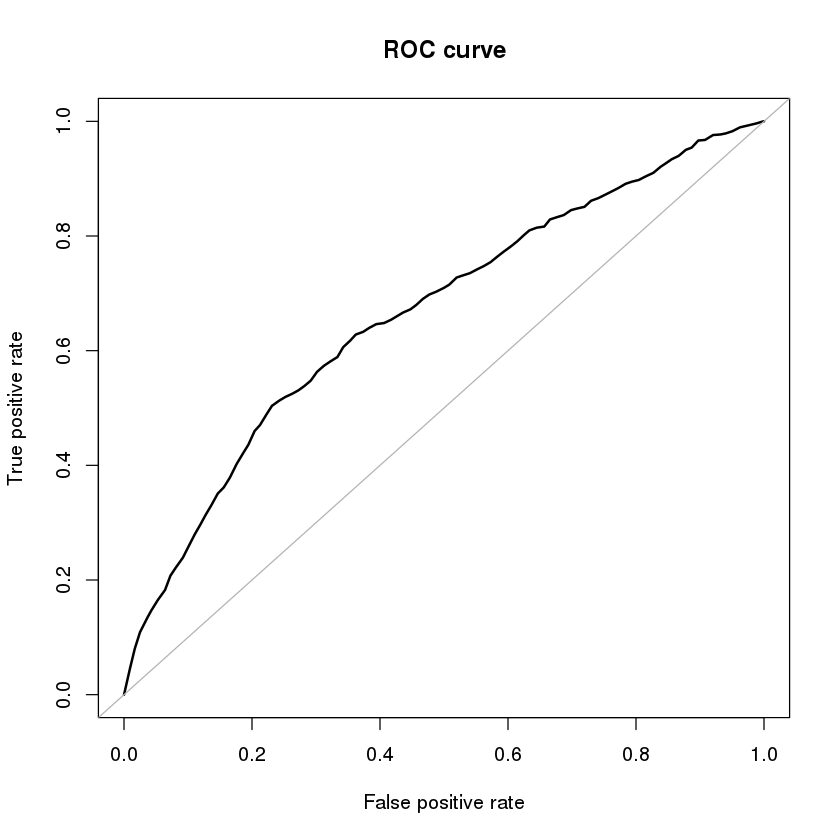

In [35]:
fit.log <- glm(y ~ age + job + marital + education + default + balance + housing + loan, 
             data=train_bank, family = binomial)
predict.log <- predict(fit.log, test_bank, type = "response")
result.log <- data.frame(y, predict.log)
roc.curve(result.log$y, result.log$predict.log)

####Already better results than the random forest, try with ROSE trainset

Area under the curve (AUC): 0.664

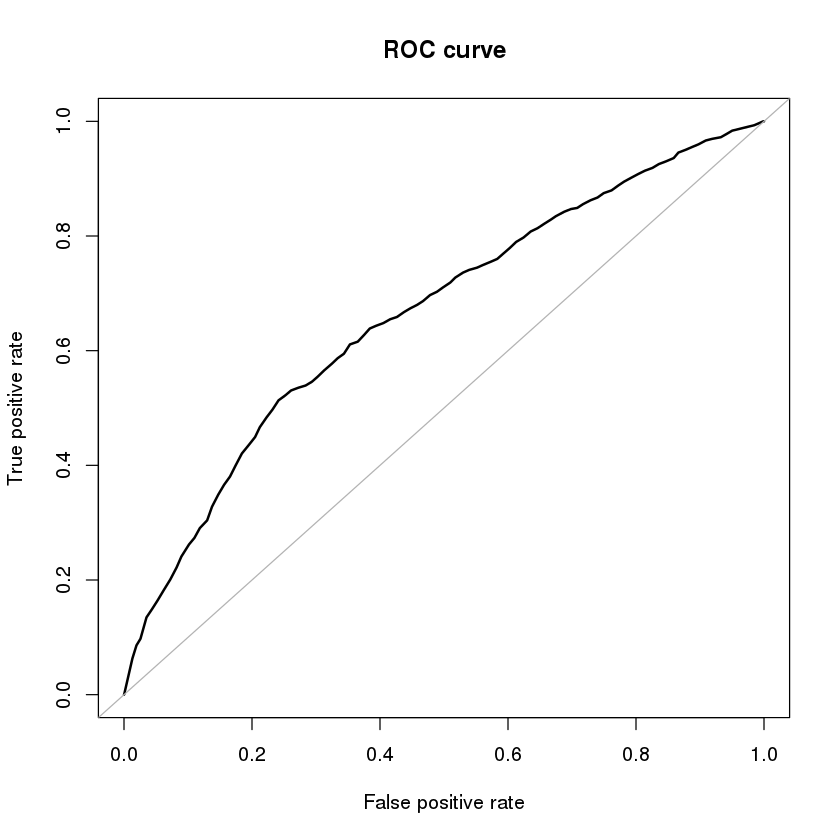

In [36]:
fit.log.rose <- glm(y ~ age + job + marital + education + default + balance + housing + loan, 
             data=bankT.rose, family = binomial)
predict.log.rose <- predict(fit.log.rose, test_bank, type = "response")
result.log.rose <- data.frame(y, predict.log.rose)
roc.curve(result.log.rose$y, result.log.rose$predict.log.rose)

####Right about the same

###The nice thing about the logarithmic model is that since a value between 0 and 1 is returned, we can specify a threshold that we consider a "yes" or "no"

####This is nice for this dataset because more true positives is much more important than getting low false negative. For example set the threshold to a conservative value and then a much more aggresive value.

Area under the curve (AUC): 0.636

     
        no  yes
  no  6074 1923
  yes  511  535

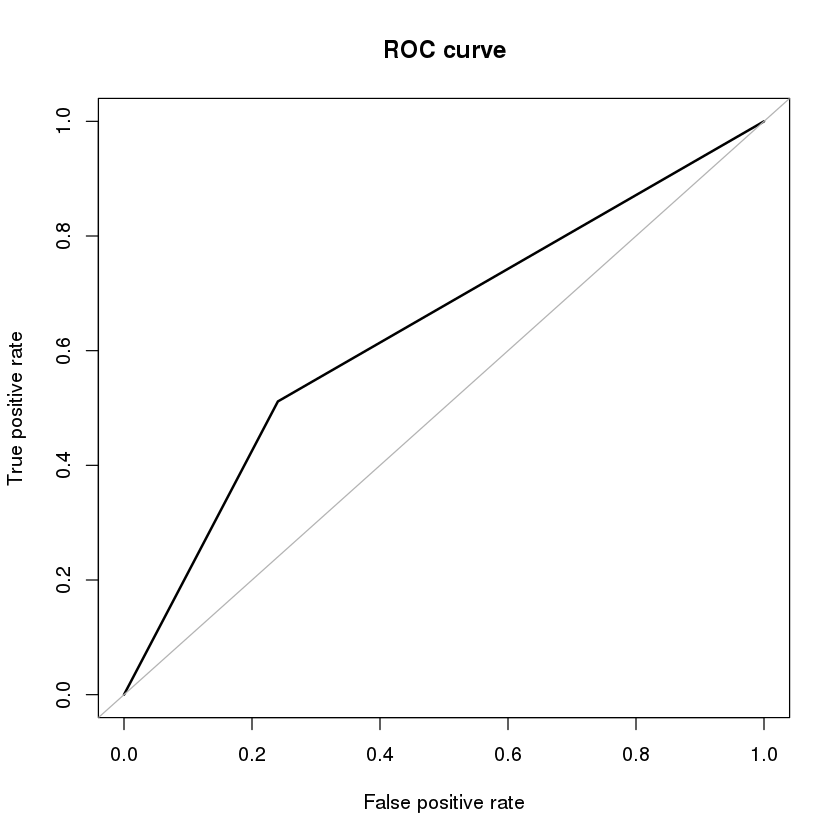

In [40]:
result.log.lowThreshold <- mutate(result.log, atThreshold = ifelse(predict.log >= .15, "yes", "no"))
roc.curve(result.log.lowThreshold$y, result.log.lowThreshold$atThreshold)
table(result.log.lowThreshold$y, result.log.lowThreshold$atThreshold)

Area under the curve (AUC): 0.574

     
        no  yes
  no  2428 5569
  yes  163  883

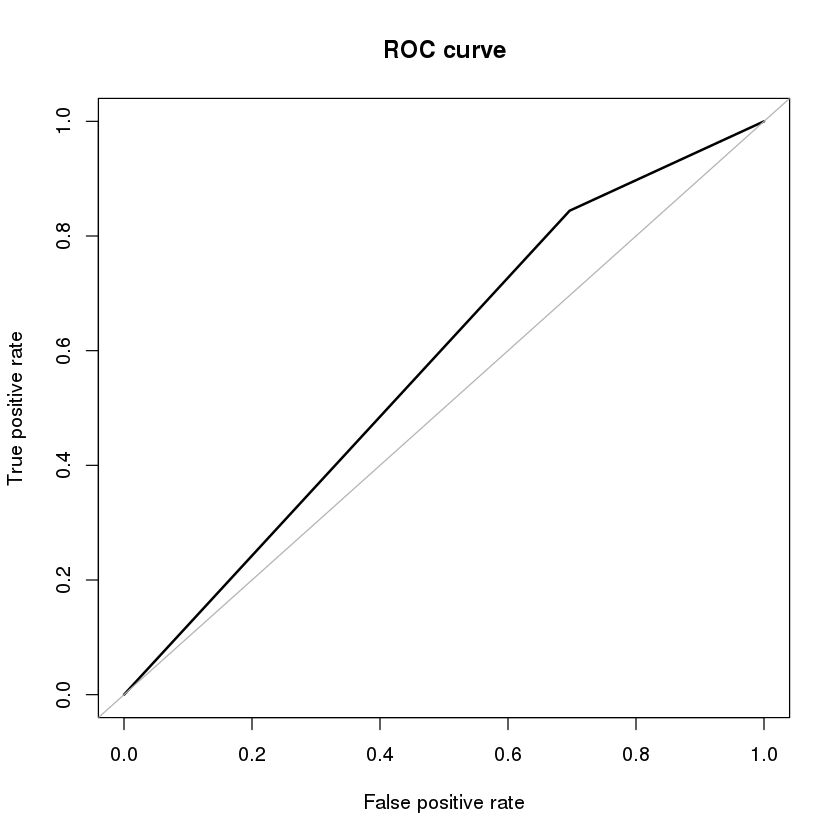

In [41]:
result.log.lowThreshold <- mutate(result.log, atThreshold = ifelse(predict.log >= .07, "yes", "no"))
roc.curve(result.log.lowThreshold$y, result.log.lowThreshold$atThreshold)
table(result.log.lowThreshold$y, result.log.lowThreshold$atThreshold)

####The AUC is worse than the more conservative threshold but we are able to call about 85% of the true positives. 

# Use same procedure as above but include variables that would only be known after the campaign has started (use ROSE train set) 

####NOTE: Variable "duration" will never be included in the model. When customers agree to sign up for a term deposit they spend a longer period of time on the phone. This gives duration an extreme amount of prediction power, but since its value wouldnt be known until after the person agrees it should be left out.

In [43]:
fit.forest.camp <- randomForest(y ~ age + job + marital + education + default + balance + housing + loan
                    + contact + day + month + campaign + pdays + previous,
                    data=bankT.rose, importance=TRUE, ntree=1001)

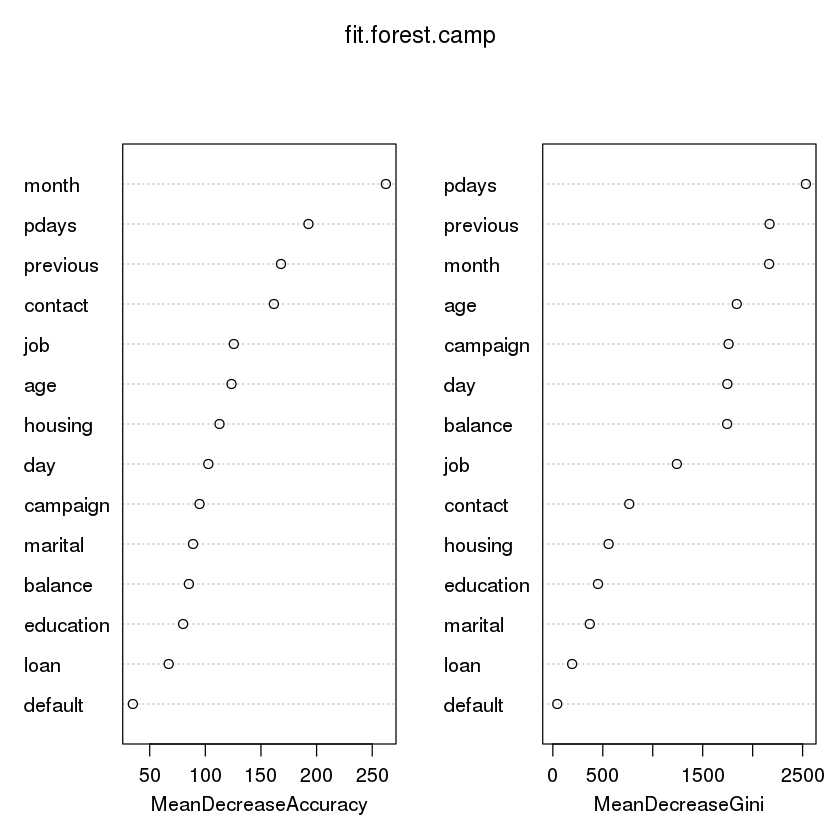

Area under the curve (AUC): 0.724

     
        no  yes
  no  7088  909
  yes  459  587

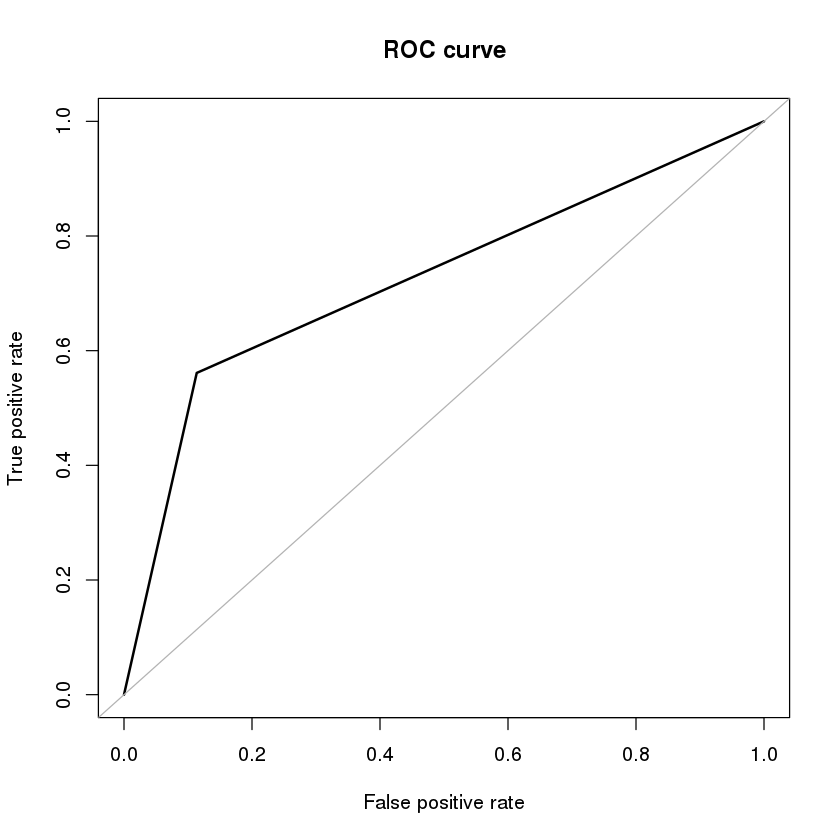

In [44]:
varImpPlot(fit.forest.camp)
predict.forest.camp <- predict(fit.forest.camp,test_bank) 
result.forest.camp <- data.frame(y, predict.forest.camp)

roc.curve(result.forest.camp$y, result.forest.camp$predict.forest.camp)
table(result.forest.camp$y, result.forest.camp$predict.forest.camp)

#### Using the variables that can only be collected as the campaign progresses improves the model, the bank might feed customers into this model after collecting some of the other info needed.

##Same thing but with logrithmic

Area under the curve (AUC): 0.746

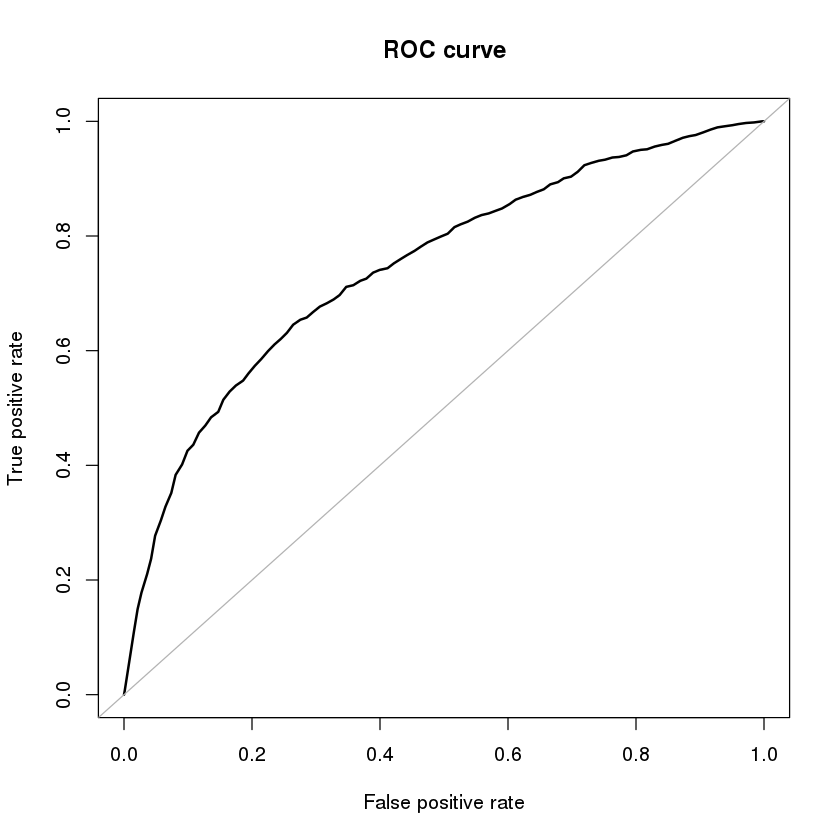

In [45]:
fit.log.camp <- glm(y ~ age + job + marital + education + default + balance + housing + loan
                    + contact + day + month + campaign + pdays + previous, 
                    data=bankT.rose, family = binomial)
predict.log.camp <- predict(fit.log.camp, test_bank, type = "response")
result.log.camp <- data.frame(y, predict.log.camp)
roc.curve(result.log.camp$y, result.log.camp$predict.log.camp)

####set thresholds again

Area under the curve (AUC): 0.611

     
        no  yes
  no  4296 3701
  yes  329  717

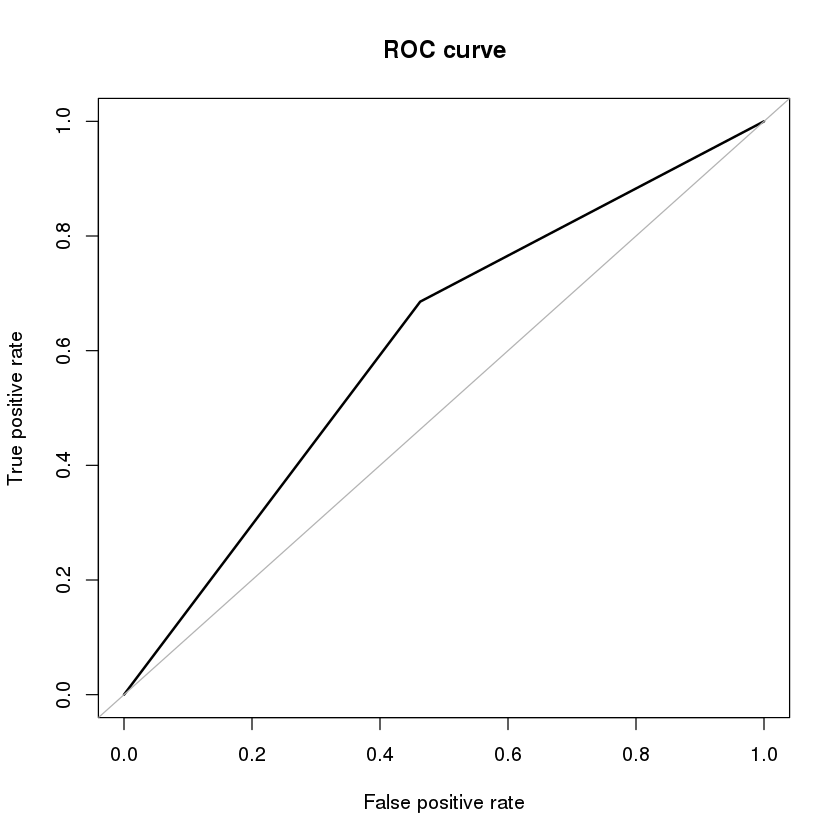

In [54]:
result.log.lowThreshold.camp <- mutate(result.log.camp, atThreshold = ifelse(predict.log >= .1, "yes", "no"))
roc.curve(result.log.lowThreshold.camp$y, result.log.lowThreshold.camp$atThreshold)
table(result.log.lowThreshold.camp$y, result.log.lowThreshold.camp$atThreshold)

####Again, the threshold can be set, but it looks like with the new variables we are able to get more true positives per false negatives

# Next I will look at SVM and neural nets